In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os

df = pd.read_csv(os.path.join(os.getcwd(),'cansim-0800020-eng-6674700030567901031.csv'),
                 skiprows=6, skipfooter=9,
                 engine='python')
df.head()

/home/sjhyeon/venv/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


,Adjustments,Unadjusted,Seasonally adjusted
0,Jan-1991,12588862,15026890
1,Feb-1991,12154321,15304585
2,Mar-1991,14337072,15413591
3,Apr-1991,15108570,15293409
4,May-1991,17225734,15676083


             Unadjusted  Seasonally adjusted
Adjustments                                 
1991-01-31     12588862             15026890
1991-02-28     12154321             15304585
1991-03-31     14337072             15413591
1991-04-30     15108570             15293409
1991-05-31     17225734             15676083


<AxesSubplot:xlabel='Adjustments'>

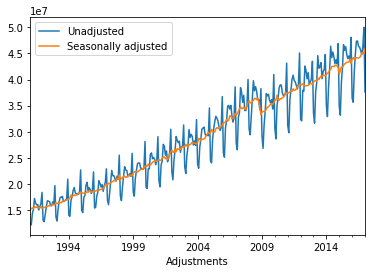

In [2]:
#전처리
from pandas.tseries.offsets import MonthEnd 

df['Adjustments'] = pd.to_datetime(df['Adjustments']) + MonthEnd(1) 

df = df.set_index('Adjustments') 

print(df.head()) 

df.plot()


우리가 학습할 변수는 파란색 선 Unadjusted 입니다.

### 트레이닝셋 테스트셋 SPLIT

2011/1/1 을 기준으로 트레이닝셋과 테스트셋으로 구분합니다. 그리고 학습과 테스트에 사용할 Unadjusted 변수만 남겨놓습니다.


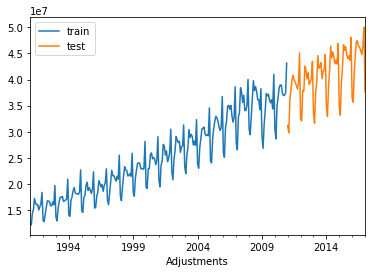

In [3]:
split_date = pd.Timestamp('01-01-2011')
# 2011/1/1 까지의 데이터를 트레이닝셋.
# 그 이후 데이터를 테스트셋으로 한다.

train = df.loc[:split_date, ['Unadjusted']]
test = df.loc[split_date:, ['Unadjusted']]
# Feature는 Unadjusted 한 개

ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])


### 변수 Scaling



MinMax Scaling을 통해 변수를 Scaling합니다. MinMax Scaling : http://3months.tistory.com/167

특정 구역의 합이 1이 되도록 숫자를 변경한다.

그러면 아래와 같이 Scaling 된 것을 볼 수 있고, scaling의 결과는 2차원의 numpy ndarray 타입으로 변환이 되게 됩니다.


In [4]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

train_sc


array([[0.01402033],
       [0.        ],
       [0.0704258 ],
       [0.09531795],
       [0.16362761],
       [0.13514108],
       [0.12395846],
       [0.12617398],
       [0.09230917],
       [0.11139526],
       [0.13173822],
       [0.20091289],
       [0.03002688],
       [0.01999285],
       [0.06596369],
       [0.10983126],
       [0.14912986],
       [0.14718865],
       [0.14464787],
       [0.11898427],
       [0.11802682],
       [0.14222108],
       [0.12459168],
       [0.24290801],
       [0.04899091],
       [0.02408276],
       [0.09865054],
       [0.14480155],
       [0.17061844],
       [0.17067229],
       [0.17603636],
       [0.1449117 ],
       [0.14957943],
       [0.15381982],
       [0.16036484],
       [0.28308682],
       [0.05971347],
       [0.05306762],
       [0.15199345],
       [0.17230214],
       [0.21246911],
       [0.23131079],
       [0.1982186 ],
       [0.19187716],
       [0.19381714],
       [0.18857277],
       [0.20528237],
       [0.339

### Pandas Dataframe으로 변환


In [5]:
train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test.index)
train_sc_df.head()


,Scaled
Adjustments,
1991-01-31,0.014020
1991-02-28,0.000000
1991-03-31,0.070426
1991-04-30,0.095318
1991-05-31,0.163628


### pandas shift를 통해 Window 만들기



shift는 이전 정보 다음 row에서 다시 쓰기 위한 pandas의 함수입니다. 

이를 통해 아래와 같이 과거의 값들을 shift_s 와 같은 형태로 저장할 수 있습니다. 

과거값은 총 12개를 저장하며, timestep은 12개가 됩니다. 우리의 목적은 과거값 shift1~12를 통해 현재값 Scaled를 예측하는 것입니다.



In [6]:
for s in range(1, 13):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)

train_sc_df.head(13)

,Scaled,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
Adjustments,,,,,,,,,,,,,
1991-01-31,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-02-28,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-03-31,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-04-30,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-05-31,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-06-30,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-07-31,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN
1991-08-31,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN
1991-09-30,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN


In [12]:
X_train = train_sc_df.dropna().drop('Scaled', axis=1)
y_train = train_sc_df.dropna()[['Scaled']]

X_test = test_sc_df.dropna().drop('Scaled', axis=1)
y_test = test_sc_df.dropna()[['Scaled']]


In [13]:
X_train.head()

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
Adjustments,,,,,,,,,,,,
1992-01-31,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020
1992-02-29,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000
1992-03-31,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426
1992-04-30,0.065964,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318
1992-05-31,0.109831,0.065964,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628


In [14]:
y_train.head()

,Scaled
Adjustments,
1992-01-31,0.030027
1992-02-29,0.019993
1992-03-31,0.065964
1992-04-30,0.109831
1992-05-31,0.149130


In [15]:
X_train = X_train.values
X_test= X_test.values

y_train = y_train.values
y_test = y_test.values
print(X_train.shape)
print(X_train)
print(y_train.shape)
print(y_train)


(228, 12)
[[0.20091289 0.13173822 0.11139526 ... 0.0704258  0.         0.01402033]
 [0.03002688 0.20091289 0.13173822 ... 0.09531795 0.0704258  0.        ]
 [0.01999285 0.03002688 0.20091289 ... 0.16362761 0.09531795 0.0704258 ]
 ...
 [0.79916654 0.81439355 0.86398323 ... 0.92972161 0.71629034 0.77368724]
 [0.80210057 0.79916654 0.81439355 ... 0.59734863 0.92972161 0.71629034]
 [0.81482896 0.80210057 0.79916654 ... 0.53166512 0.59734863 0.92972161]]
(228, 1)
[[0.03002688]
 [0.01999285]
 [0.06596369]
 [0.10983126]
 [0.14912986]
 [0.14718865]
 [0.14464787]
 [0.11898427]
 [0.11802682]
 [0.14222108]
 [0.12459168]
 [0.24290801]
 [0.04899091]
 [0.02408276]
 [0.09865054]
 [0.14480155]
 [0.17061844]
 [0.17067229]
 [0.17603636]
 [0.1449117 ]
 [0.14957943]
 [0.15381982]
 [0.16036484]
 [0.28308682]
 [0.05971347]
 [0.05306762]
 [0.15199345]
 [0.17230214]
 [0.21246911]
 [0.23131079]
 [0.1982186 ]
 [0.19187716]
 [0.19381714]
 [0.18857277]
 [0.20528237]
 [0.33988685]
 [0.08949179]
 [0.07634802]
 [0.1

### 최종 트레이닝셋과 테스트셋의 X 만들기



이부분이 중요한데, keras에서는 RNN 계열의 모델을 트레이닝할 때 요구되는 데이터의 형식이 있습니다. 

바로 3차원 데이터여야하며 각각의 차원은 (size, timestep, feature) 을 순서대로 나타내주어야하는 것입니다. 

따라서 이 형태로 데이터를 reshape 해주어야합니다. 

일반적인 MLP 모델에서는 size와 feature만 있기 때문에 2차원이지만, 

RNN에서는 "시간" 이라는 개념이 있기 때문에 차원이 한 차원 늘어나게 된 것입니다. 



아래 코드를 통해 Training set과 Test set의 X를 RNN 학습에 맞는 형태로 reshape 해줍니다.

In [16]:
X_train_t = X_train.reshape(X_train.shape[0], 12, 1)
X_test_t = X_test.reshape(X_test.shape[0], 12, 1)

print("최종 DATA")
print(X_train_t.shape)
print(X_train_t)
print(y_train)

최종 DATA
(228, 12, 1)
[[[0.20091289]
  [0.13173822]
  [0.11139526]
  ...
  [0.0704258 ]
  [0.        ]
  [0.01402033]]

 [[0.03002688]
  [0.20091289]
  [0.13173822]
  ...
  [0.09531795]
  [0.0704258 ]
  [0.        ]]

 [[0.01999285]
  [0.03002688]
  [0.20091289]
  ...
  [0.16362761]
  [0.09531795]
  [0.0704258 ]]

 ...

 [[0.79916654]
  [0.81439355]
  [0.86398323]
  ...
  [0.92972161]
  [0.71629034]
  [0.77368724]]

 [[0.80210057]
  [0.79916654]
  [0.81439355]
  ...
  [0.59734863]
  [0.92972161]
  [0.71629034]]

 [[0.81482896]
  [0.80210057]
  [0.79916654]
  ...
  [0.53166512]
  [0.59734863]
  [0.92972161]]]
[[0.03002688]
 [0.01999285]
 [0.06596369]
 [0.10983126]
 [0.14912986]
 [0.14718865]
 [0.14464787]
 [0.11898427]
 [0.11802682]
 [0.14222108]
 [0.12459168]
 [0.24290801]
 [0.04899091]
 [0.02408276]
 [0.09865054]
 [0.14480155]
 [0.17061844]
 [0.17067229]
 [0.17603636]
 [0.1449117 ]
 [0.14957943]
 [0.15381982]
 [0.16036484]
 [0.28308682]
 [0.05971347]
 [0.05306762]
 [0.15199345]
 [0.172

### LSTM 모델 만들기


input_shape=(timestep, feature)으로 만들어줍니다. 

size는 모델 설계시에는 중요하지 않으므로, feature, timestep만 모델에 알려주면 됩니다. 

또 예측하고자하는 target의 갯수가 1이므로 마지막에 Dense(1)을 하나 추가해줍니다. 

또한 실제 연속적인 값을 예측하는 것이기 때문에 loss function은 mean squared error가 됩니다. 

또한 일반적으로 optimizer는 adam을 자주 사용합니다.



In [17]:
from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping 

K.clear_session() 
model = Sequential() # Sequeatial Model 
model.add(LSTM(20, input_shape=(12, 1))) # (timestep, feature) 
model.add(Dense(1)) # output = 1 
model.compile(loss='mean_squared_error', optimizer='adam') 
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                1760      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


### 모델 Fitting



모델을 Fitting한다는 것은 Training data set으로 optimization 과정을 통해 모델의 weight를 찾는 것입니다. 

early stopping 객체를 이용해 epoch마다 early stopping을 체크합니다. 


In [22]:
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)

model.fit(X_train_t, y_train, epochs=200,
          batch_size=30, verbose=1, callbacks=[early_stop])

Epoch 1/200
8/8 [==============================] - 0s 5ms/step - loss: 0.0160
Epoch 2/200
8/8 [==============================] - 0s 5ms/step - loss: 0.0132
Epoch 3/200
8/8 [==============================] - 0s 4ms/step - loss: 0.0124
Epoch 4/200
8/8 [==============================] - 0s 4ms/step - loss: 0.0114
Epoch 5/200
8/8 [==============================] - 0s 4ms/step - loss: 0.0104
Epoch 6/200
8/8 [==============================] - 0s 4ms/step - loss: 0.0098
Epoch 7/200
8/8 [==============================] - 0s 4ms/step - loss: 0.0093
Epoch 8/200
8/8 [==============================] - 0s 4ms/step - loss: 0.0090
Epoch 9/200
8/8 [==============================] - 0s 4ms/step - loss: 0.0087
Epoch 10/200
8/8 [==============================] - 0s 4ms/step - loss: 0.0085
Epoch 11/200
8/8 [==============================] - 0s 4ms/step - loss: 0.0085
Epoch 12/200
8/8 [==============================] - 0s 4ms/step - loss: 0.0084
Epoch 13/200
8/8 [==============================] - 0s 4ms/st

8/8 [==============================] - 0s 4ms/step - loss: 0.0046
Epoch 105/200
8/8 [==============================] - 0s 4ms/step - loss: 0.0044
Epoch 106/200
8/8 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 107/200
8/8 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 108/200
8/8 [==============================] - 0s 4ms/step - loss: 0.0041
Epoch 109/200
8/8 [==============================] - 0s 4ms/step - loss: 0.0040
Epoch 110/200
8/8 [==============================] - 0s 4ms/step - loss: 0.0039
Epoch 111/200
8/8 [==============================] - 0s 4ms/step - loss: 0.0038
Epoch 112/200
8/8 [==============================] - 0s 4ms/step - loss: 0.0038
Epoch 113/200
8/8 [==============================] - 0s 5ms/step - loss: 0.0036
Epoch 114/200
8/8 [==============================] - 0s 4ms/step - loss: 0.0035
Epoch 115/200
8/8 [==============================] - 0s 4ms/step - loss: 0.0033
Epoch 116/200
8/8 [==============================] - 0

### 학습된 모델을 통해 테스트셋 Test 하기



테스트셋은 2011/1/1 이후의 데이터를 나타냅니다. 

트레이닝에는 1991년~ 2010년 까지 데이터가 이용되었기 때문에, 

이 실습은 1991년~2010년 데이터를 통해 2011년 이후의 데이터를 예측하는 것으로 볼 수 있습니다.


In [23]:
print(X_test_t)

[[[1.06265011]
  [0.87180554]
  [0.84048091]
  [0.86220767]
  [0.88363094]
  [0.89302107]
  [0.92552046]
  [0.89993326]
  [0.83505683]
  [0.77259579]
  [0.56926634]
  [0.61423187]]

 [[0.65198848]
  [1.06265011]
  [0.87180554]
  [0.84048091]
  [0.86220767]
  [0.88363094]
  [0.89302107]
  [0.92552046]
  [0.89993326]
  [0.83505683]
  [0.77259579]
  [0.56926634]]

 [[0.6431242 ]
  [0.65198848]
  [1.06265011]
  [0.87180554]
  [0.84048091]
  [0.86220767]
  [0.88363094]
  [0.89302107]
  [0.92552046]
  [0.89993326]
  [0.83505683]
  [0.77259579]]

 [[0.83176496]
  [0.6431242 ]
  [0.65198848]
  [1.06265011]
  [0.87180554]
  [0.84048091]
  [0.86220767]
  [0.88363094]
  [0.89302107]
  [0.92552046]
  [0.89993326]
  [0.83505683]]

 [[0.82666946]
  [0.83176496]
  [0.6431242 ]
  [0.65198848]
  [1.06265011]
  [0.87180554]
  [0.84048091]
  [0.86220767]
  [0.88363094]
  [0.89302107]
  [0.92552046]
  [0.89993326]]

 [[0.98182284]
  [0.82666946]
  [0.83176496]
  [0.6431242 ]
  [0.65198848]
  [1.06265011]


model.predict를 통해 테스트셋의 X에 대한 예측값 y_hat을 얻을 수 있습니다.


In [24]:
y_pred = model.predict(X_test_t)
print(y_pred)


[[0.6463748 ]
 [0.5980689 ]
 [0.7816501 ]
 [0.8386394 ]
 [0.8988089 ]
 [0.9255371 ]
 [0.89923745]
 [0.8924953 ]
 [0.8742271 ]
 [0.8556616 ]
 [0.8968602 ]
 [1.0716994 ]
 [0.6804395 ]
 [0.66701615]
 [0.8335819 ]
 [0.82986474]
 [0.9715486 ]
 [0.95249134]
 [0.9083726 ]
 [0.9463896 ]
 [0.88300586]
 [0.8983318 ]
 [0.9265073 ]
 [1.0297855 ]
 [0.72104645]
 [0.6540708 ]
 [0.82360256]
 [0.87925774]
 [1.0290167 ]
 [0.9639234 ]
 [0.97608936]
 [1.0034344 ]
 [0.9166296 ]
 [0.96127844]
 [0.98068887]
 [1.0692307 ]
 [0.7658913 ]
 [0.6921459 ]
 [0.85032195]
 [0.94841856]
 [1.0776923 ]
 [1.0197049 ]
 [1.0553632 ]
 [1.0332109 ]
 [0.99883103]
 [1.0250828 ]
 [1.0128138 ]
 [1.1304928 ]
 [0.76146656]
 [0.70204735]
 [0.88152015]
 [0.96448505]
 [1.0891801 ]
 [1.0626837 ]
 [1.0867577 ]
 [1.0472342 ]
 [1.0279894 ]
 [1.0458635 ]
 [1.0315493 ]
 [1.1613846 ]
 [0.80902797]]


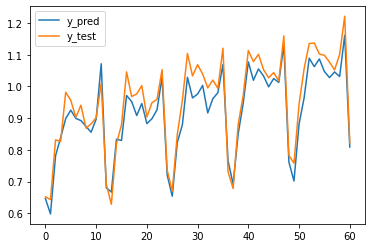

In [27]:
plt.figure()
plt.plot(y_pred, label='y_pred')
plt.plot(y_test, label='y_test')
plt.legend()

Keras에서 만든 모델을 저장할 때는 다음과 같은 룰을 따릅니다.

- 모델은 JSON 파일 또는 YAML 파일로 저장한다.
- Weight는 H5 파일로 저장한다.


In [28]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy
import pandas as pd


In [29]:
model_json = model.to_json()
with open(os.path.join(os.getcwd(),"model.json"), "w") as json_file : 
    json_file.write(model_json)

In [30]:
# Weight를 h5 파일 포맷으로 만들어 저장하기
model.save_weights(os.path.join(os.getcwd(), "model.h5"))
print("Saved model to disk")


Saved model to disk


In [31]:

#  저장된 JSON 파일로 부터 모델 로드하기
from keras.models import model_from_json 
json_file = open("model.json", "r") 
loaded_model_json = json_file.read() 
json_file.close() 
loaded_model = model_from_json(loaded_model_json)


In [32]:
# 로드한 모델에 Weight 로드하기
loaded_model.load_weights("model.h5")
print("Loaded model from disk")


Loaded model from disk


In [33]:
# loaded_model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=['accuracy'])

loaded_model.compile(loss='mean_squared_error', optimizer='adam') 
loaded_model.summary()

# model evaluation
# score = loaded_model.evaluate(X,Y,verbose=0)

# print("%s : %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                1760      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________
